In [ ]:
 #mount to google drive

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchbnn


In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.distributions import MultivariateNormal, Normal, Bernoulli, kl_divergence as kl


def get_act(act="relu"):
    if act=="relu":         return nn.ReLU()
    elif act=="elu":        return nn.ELU()
    elif act=="celu":       return nn.CELU()
    elif act=="leaky_relu": return nn.LeakyReLU()
    elif act=="sigmoid":    return nn.Sigmoid()
    elif act=="tanh":       return nn.Tanh()
    elif act=="linear":     return nn.Identity()
    elif act=='softplus':   return nn.modules.activation.Softplus()
    else:                   return None


class BNN(nn.Module):
    def __init__(self, n_in: int, n_out: int, n_hid_layers: int=2, act: str='softplus', dropout=0.0, \
                        n_hidden: int=100, requires_grad=True, logsig0=-3, bnn=True, layer_norm=False):
        super().__init__()
        layers_dim = [n_in] + n_hid_layers*[n_hidden] + [n_out]
        self.weight_mus  = nn.ParameterList([])
        self.bias_mus    = nn.ParameterList([])
        self.layer_norms = nn.ModuleList([])
        self.dropout_rate = dropout
        self.dropout = nn.Dropout(dropout)
        self.acts    = []
        self.act = act 
        self.bnn = bnn
        for i,(n_in,n_out) in enumerate(zip(layers_dim[:-1],layers_dim[1:])):
            self.weight_mus.append(Parameter(torch.Tensor(n_out, n_in),requires_grad=requires_grad))
            self.bias_mus.append(Parameter(torch.Tensor(n_out),requires_grad=requires_grad))
            self.acts.append(get_act(act) if i<n_hid_layers else get_act('linear')) # no act. in final layer
            self.layer_norms.append(nn.LayerNorm(n_out) if layer_norm and i<n_hid_layers else nn.Identity())
        if bnn:
            self.weight_logsigs = nn.ParameterList([])
            self.bias_logsigs   = nn.ParameterList([])
            self.logsig0 = logsig0
            for i,(n_in,n_out) in enumerate(zip(layers_dim[:-1],layers_dim[1:])):
                self.weight_logsigs.append(Parameter(torch.Tensor(n_out, n_in),requires_grad=requires_grad))
                self.bias_logsigs.append(Parameter(torch.Tensor(n_out),requires_grad=requires_grad))
        self.reset_parameters()

    def reset_parameters(self,gain=1.0):
        for i,(weight,bias) in enumerate(zip(self.weight_mus,self.bias_mus)):
            nn.init.xavier_uniform_(weight,gain)
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(bias, -bound, bound)
        for norm in self.layer_norms[:-1]:
            if isinstance(norm,nn.LayerNorm):
                norm.reset_parameters()
        if self.bnn:
            for w,b in zip(self.weight_logsigs,self.bias_logsigs):
                nn.init.uniform_(w,self.logsig0-1,self.logsig0+1)
                nn.init.uniform_(b,self.logsig0-1,self.logsig0+1)

    def __sample_weights(self,mean=False):
        if self.bnn and not mean:
            weights = [weight_mu + torch.randn_like(weight_mu)*weight_sig.exp() \
                for weight_mu,weight_sig in zip(self.weight_mus,self.weight_logsigs)]
            biases  = [bias_mu + torch.randn_like(bias_mu)*bias_sig.exp() \
                for bias_mu,bias_sig in zip(self.bias_mus,self.bias_logsigs)]
        else:
            weights = self.weight_mus
            biases  = self.bias_mus
        return weights,biases

    def draw_f(self,mean=False):
        weights,biases = self.__sample_weights(mean)
        def f(x):
            for (weight,bias,act,norm) in zip(weights,biases,self.acts,self.layer_norms):
                x = norm(act(self.dropout(F.linear(x,weight,bias))))
            return x
        return f

    def forward(self, x):
        return self.draw_f()(x)

    def kl(self):
        w_mus = [weight_mu.view([-1]) for weight_mu in self.weight_mus]
        b_mus = [bias_mu.view([-1]) for bias_mu in self.bias_mus]
        mus = torch.cat(w_mus+b_mus)
        w_logsigs = [weight_logsig.view([-1]) for weight_logsig in self.weight_logsigs]
        b_logsigs = [bias_logsigs.view([-1]) for bias_logsigs in self.bias_logsigs]
        sigs = torch.cat(w_logsigs+b_logsigs).exp()
        q = Normal(mus,sigs)
        N = Normal(torch.zeros(len(mus),device=mus.device),torch.ones(len(mus),device=mus.device))
        return kl(q,N)

    def __repr__(self):
        str_ = 'dropout rate = {:.2f}\n'.format(self.dropout_rate)
        for i,(weight,act) in enumerate(zip(self.weight_mus,self.acts)):
            str_ += 'Layer-{:d}: '.format(i+1) + ''.join(str([*weight.shape][::-1])) \
                + '\t' + str(act) + '\n'
        return str_

In [ ]:
pip install torchdiffeq


In [ ]:
import numpy as np
import tensorflow as tf
import scipy.stats as ss
import os

import tensorflow_probability as tfp
tfd = tfp.distributions

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import functional_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import ops

import glob
import os
import numpy as np
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
import math

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence


import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils import data
from torch.distributions import MultivariateNormal, Normal, kl_divergence as kl
#from torch_bnn import BNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchdiffeq import odeint


In [ ]:
# set the path to overarching project folder within google drive 
tmlps_dir = '/content/drive/MyDrive/zipped_timelapses'

# set the path to overarching timelapse folder within google drive 
#tmlps_dir = project_dir + 'timelapses/' 

# set the paths to the sub-directories containing train, val, & test timelapses
train_dir = tmlps_dir + '/train'
val_dir = tmlps_dir + '/val'
test_dir = tmlps_dir + '/test'



In [ ]:
# definition for getting paths to each individual timelapse folder

def get_tmlps_paths(dir):

  # get list of individual tmlps expts
  unzip_tmlps_paths = glob.glob(dir + "/*(Unzipped Files)")

  # empty array for storing individual tmlps paths
  individ_tmlps_paths = []

  # loop through the individual tmlps folders
  for u in unzip_tmlps_paths:
    # the tmlps frames are actually stored in a sub-folder '*_polarims'
    polarim_fold = glob.glob(u + "/*_polarims")
    individ_tmlps_paths.append(polarim_fold[0])

  return individ_tmlps_paths

In [ ]:
# get paths to individual train, val, & test timelapses
train_tmlps_paths = get_tmlps_paths(train_dir)
val_tmlps_paths = get_tmlps_paths(val_dir)
test_tmlps_paths = get_tmlps_paths(test_dir)

# print number of timelapses
print(str(len(train_tmlps_paths)) + ' train timelapses')
print(str(len(val_tmlps_paths)) + ' val timelapses')
print(str(len(test_tmlps_paths)) + ' test timelapses')

36 train timelapses
5 val timelapses
5 test timelapses


In [ ]:
# definition for determining min number of frames available across all timelapses
def get_tmlps_length(all_tmlps_paths):
    num_frames_list = []
    for p in all_tmlps_paths:
        frames_list = os.listdir(p)
        num_frames = len(frames_list)
        num_frames_list.append(num_frames)
    tmlps_length = min(num_frames_list)   
    return tmlps_length    

In [ ]:
# determining min number of frames available
all_tmlps_paths = train_tmlps_paths + val_tmlps_paths + test_tmlps_paths
tmlps_length = get_tmlps_length(all_tmlps_paths)
print('All timelapses have at least ' + str(tmlps_length) + ' frames')

All timelapses have at least 156 frames


In [ ]:
# Custom data generator

class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self, tmlps_paths, tmlps_length, start_frame=0, time_step=1, frame_height=64, frame_width=64, batch_size=5, shuffle=True):

    'Initilization'
    self.tmlps_paths = tmlps_paths
    self.tmlps_length = tmlps_length
    self.start_frame = start_frame
    self.time_step = time_step
    self.frame_height = frame_height
    self.frame_width = frame_width
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.tmlps_paths) / self.batch_size))

  def __getitem__(self, index):
    'Generates one batch of data (index = index of the batch)'
    # generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # find list of paths
    tmlps_paths_temp = [self.tmlps_paths[k] for k in indexes]

    # generate data
    dataset = self.extract_frames(tmlps_paths_temp)
    return dataset

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.tmlps_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def extract_frames(self, tmlps_paths_temp):
    # determine how many timelapses in each batch (should be batch_size)
    num_tmlps = len(tmlps_paths_temp)

    # determine how many frames we'll use from each tmlps
    num_frames = int(np.floor((self.tmlps_length-self.start_frame)/self.time_step))

    # set up array for storing timelapse frames
    dataset = np.empty(shape=(num_tmlps, num_frames, self.frame_height, self.frame_width)) 

    # loop through each timelapse & store frames
    for t in range(num_tmlps):
      # get individual tmlps path
      path_t = tmlps_paths_temp[t]
      # get list of image frames in a single timelapse
      frames_list = glob.glob(path_t + "/*.tif")
      # sort the frames in order
      frames_list.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
      # grab every 'time_step' frames, starting from 'start_frame'
      keep_frames = [frames_list[i] for i in range(self.start_frame, self.tmlps_length, self.time_step)]

      # loop through the frames & store them
      for f in range(num_frames):
        frame_path = keep_frames[f]
        # read in frame as grayscale image
        frame = cv2.imread(frame_path,cv2.IMREAD_UNCHANGED)
        # resize frame
        frame = cv2.resize(frame, (self.frame_height, self.frame_width), interpolation = cv2.INTER_NEAREST) 
        # normalize to 0-1 range
        frame = frame/255
        # store frame in dataset array
        dataset[t,f,:,:] = frame
        
    # Add a channel dimension since the images are grayscale
    dataset = np.expand_dims(dataset, axis=-1)
    return dataset

In [ ]:
# Custom data generator

class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self, tmlps_paths, tmlps_length, start_frame=0, time_step=1, frame_height=64, frame_width=64, batch_size=5, shuffle=True):

    'Initilization'
    self.tmlps_paths = tmlps_paths
    self.tmlps_length = tmlps_length
    self.start_frame = start_frame
    self.time_step = time_step
    self.frame_height = frame_height
    self.frame_width = frame_width
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.tmlps_paths) / self.batch_size))

  def __getitem__(self, index):
    'Generates one batch of data (index = index of the batch)'
    # generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # find list of paths
    tmlps_paths_temp = [self.tmlps_paths[k] for k in indexes]

    # generate data
    dataset = self.extract_frames(tmlps_paths_temp)

    # shift the frames
    x, y = self.shift_frames(dataset)
    return x, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.tmlps_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def extract_frames(self, tmlps_paths_temp):
    # determine how many timelapses in each batch (should be batch_size)
    num_tmlps = len(tmlps_paths_temp)

    # determine how many frames we'll use from each tmlps
    num_frames = int(np.floor((self.tmlps_length-self.start_frame)/self.time_step)) 

    # set up array for storing timelapse frames
    dataset = np.empty(shape=(num_tmlps, num_frames, self.frame_height, self.frame_width)) 

    # loop through each timelapse & store frames
    for t in range(num_tmlps):
      # get individual tmlps path
      path_t = tmlps_paths_temp[t]
      # get list of image frames in a single timelapse
      frames_list = glob.glob(path_t + "/*.tif")
      # sort the frames in order
      frames_list.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

      # initialize counter for storing frames:
      count_f = 0

      # loop through the frames & store them
      for f in range(self.start_frame, self.tmlps_length, self.time_step):
        frame_path = frames_list[f]
        # read in frame as grayscale image
        frame = cv2.imread(frame_path,cv2.IMREAD_UNCHANGED)
        # resize frame
        frame = cv2.resize(frame, (self.frame_height, self.frame_width), interpolation = cv2.INTER_NEAREST) 
        # normalize to 0-1 range
        frame = frame/255
        # store frame in dataset array
        dataset[t,count_f,:,:] = frame
        # update counter
        count_f = count_f + 1
        
    # Add a channel dimension since the images are grayscale
    dataset = np.expand_dims(dataset, axis=-1)
    return dataset

  # function for shifting frames
  # where `x` is frames 0 to n - 1, and `y` is frames 1 to n.
  def shift_frames(self, dataset):
    x = dataset[:, 0:dataset.shape[1]-1, :, :]
    y = dataset[:, 1:dataset.shape[1], :, :]
    return x, y


In [ ]:
# Set parameters for data generators
start_frame=tmlps_length-20 #for now, let's just train on the last 20 frames
time_step=1 #for now, let's not skip any of the last 20 frames
frame_height=28
frame_width=28
train_batch_size=1
val_batch_size=1
test_batch_size=1

In [ ]:
# data generators

train_generator = DataGenerator(train_tmlps_paths, tmlps_length, 
                                start_frame=start_frame, time_step=time_step,
                                frame_height=frame_height, frame_width=frame_width, 
                                batch_size=train_batch_size, shuffle=True)

val_generator = DataGenerator(val_tmlps_paths, tmlps_length, 
                              start_frame=start_frame, time_step=time_step,
                              frame_height=frame_height, frame_width=frame_width, 
                              batch_size=val_batch_size, shuffle=True)

test_generator = DataGenerator(test_tmlps_paths, tmlps_length, 
                              start_frame=start_frame, time_step=time_step,
                              frame_height=frame_height, frame_width=frame_width, 
                              batch_size=test_batch_size, shuffle=False)



In [ ]:
# for confirmation, print the size of 1 batch from the val data generator
x_val_0, y_val_0 = train_generator[0]
x_val_1, y_val_1 = val_generator[0]
print('Shape of shifted frame sets from a validation data batch:')
print(x_val_0.shape)
print(y_val_0.shape)
print(x_val_1.shape)
print(y_val_1.shape)

Shape of shifted frame sets from a validation data batch:
(1, 19, 28, 28, 1)
(1, 19, 28, 28, 1)
(1, 19, 28, 28, 1)
(1, 19, 28, 28, 1)


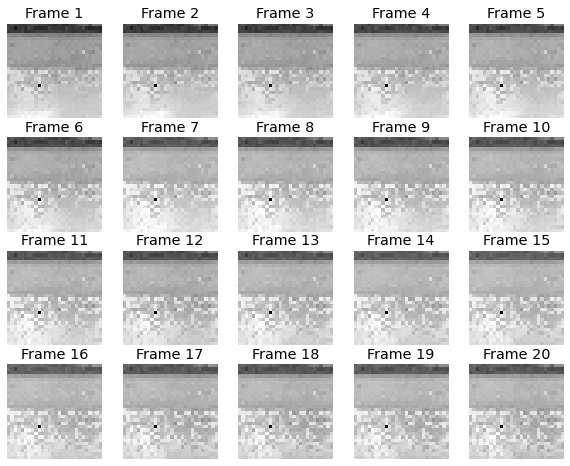

In [ ]:
# let's view the last 20 frames from a val batch 

fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
for idx, ax in enumerate(axes.flat):
  if idx < 19:
    ax.imshow(np.squeeze(x_val_0[0][idx]), cmap="gray")
  else:
    # the last frame is in the shifted y set
    ax.imshow(np.squeeze(y_val_0[0][idx-1]), cmap="gray")

  ax.set_title(f"Frame {idx + 1}")
  ax.axis("off")

plt.show()

Model Construction

In [ ]:
# Construct the input layer with no definite frame size.
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self,w):
        super().__init__()
        self.w = w
    def forward(self, input):
        nc = input[0].numel()//(self.w**2)
        return input.view(input.size(0), nc, self.w, self.w)


In [ ]:
inp = layers.Input(shape=(None, *x_val_0.shape[2:]))

class ODE2VAE(nn.Module):
    def __init__(self, n_filt=8, q=8):
        super(ODE2VAE, self).__init__()
        h_dim = n_filt*4**3 # encoder output is [4*n_filt,4,4]; H_DIM=512
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, n_filt, kernel_size=5, stride=2, padding=(2,2)), # 14,14
            nn.BatchNorm2d(n_filt),
            nn.ReLU(),   
            nn.Conv2d(n_filt, n_filt*2, kernel_size=5, stride=2, padding=(2,2)), # 7,7
            nn.BatchNorm2d(n_filt*2),
            nn.ReLU(),
            nn.Conv2d(n_filt*2, n_filt*4, kernel_size=5, stride=2, padding=(2,2)),
            nn.ReLU(),
            Flatten()
        )

        self.fc =  nn.Linear(2048, h_dim)
        self.fc1 = nn.Linear(h_dim, 2*q) #512, 2*8=16(O/P IS 16)
        self.fc2 = nn.Linear(h_dim, 2*q)
        self.fc3 = nn.Linear(q, h_dim)
        # differential function
        # to use a deterministic differential function, set bnn=False and self.beta=0.0
        self.bnn = BNN(2*q, q, n_hid_layers=2, n_hidden=50, act='celu', layer_norm=True, bnn=True)
        # downweighting the BNN KL term is helpful if self.bnn is heavily overparameterized
        self.beta = 1.0 # 2*q/self.bnn.kl().numel()
        # decoder
        self.decoder = nn.Sequential(
            UnFlatten(4),
            nn.ConvTranspose2d(h_dim//16, n_filt*8, kernel_size=3, stride=1, padding=(0,0)),
            nn.BatchNorm2d(n_filt*8),
            nn.ReLU(),
            nn.ConvTranspose2d(n_filt*8, n_filt*4, kernel_size=5, stride=2, padding=(1,1)),
            nn.BatchNorm2d(n_filt*4),
            nn.ReLU(),
            nn.ConvTranspose2d(n_filt*4, n_filt*2, kernel_size=5, stride=2, padding=(1,1), output_padding=(1,1)),
            nn.BatchNorm2d(n_filt*2),
            nn.ReLU(),
            nn.ConvTranspose2d(n_filt*2, 1, kernel_size=5, stride=1, padding=(2,2)),
            #nn.ReLU(),
            #nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=(1,1), output_padding=(1,1)),
            nn.Sigmoid(),
        )
        self._zero_mean = torch.zeros(2*q).to(device)
        self._eye_covar = torch.eye(2*q).to(device) 
        self.mvn = MultivariateNormal(self._zero_mean, self._eye_covar)
       
    def ode2vae_rhs(self,t,vs_logp,f):
        vs, logp = vs_logp # N,2q & N
        q = vs.shape[1]//2
        dv = f(vs) # N,q 
        ds = vs[:,:q]  # N,q
        dvs = torch.cat([dv,ds],1) # N,2q
        ddvi_dvi = torch.stack(
                    [torch.autograd.grad(dv[:,i],vs,torch.ones_like(dv[:,i]),
                    retain_graph=True,create_graph=True)[0].contiguous()[:,i]
                    for i in range(q)],1) # N,q --> df(x)_i/dx_i, i=1..q
        tr_ddvi_dvi = torch.sum(ddvi_dvi,1) # N
        return (dvs,-tr_ddvi_dvi)
    def elbo(self, qz_m, qz_logv, zode_L, logpL, X, XrecL, Ndata, qz_enc_m=None, qz_enc_logv=None):
        ''' Input:
                qz_m        - latent means [N,2q]
                qz_logv     - latent logvars [N,2q]
                zode_L      - latent trajectory samples [L,N,T,2q]
                logpL       - densities of latent trajectory samples [L,N,T]
                X           - input images [N,T,nc,d,d]
                XrecL       - reconstructions [L,N,T,nc,d,d]
                Ndata       - number of sequences in the dataset (required for elbo
                qz_enc_m    - encoder density means  [N*T,2*q]
                qz_enc_logv - encoder density variances [N*T,2*q]
            Returns:
                likelihood
                prior on ODE trajectories KL[q_ode(z_{0:T})||N(0,I)]
                prior on BNN weights
                instant encoding term KL[q_ode(z_{0:T})||q_enc(z_{0:T}|X_{0:T})] (if required) 
        '''
        [N,T,nc,d,d] = X.shape
        L = zode_L.shape[0]
        q = qz_m.shape[1]//2
        # prior
        log_pzt = self.mvn.log_prob(zode_L.contiguous().view([L*N*T,2*q])) # L*N*T
        log_pzt = log_pzt.view([L,N,T]) # L,N,T
        kl_zt   = logpL - log_pzt  # L,N,T
        kl_z    = kl_zt.sum(2).mean(0) # N
        kl_w    = self.bnn.kl().sum()
        # likelihood
        XL = X.repeat([L,1,1,1,1,1]) # L,N,T,nc,d,d 
        lhood_L = torch.log(1e-3+XrecL)*XL + torch.log(1e-3+1-XrecL)*(1-XL) # L,N,T,nc,d,d
        lhood = lhood_L.sum([2,3,4,5]).mean(0) # N
        if qz_enc_m is not None: # instant encoding
            qz_enc_mL    = qz_enc_m.repeat([L,1])  # L*N*T,2*q
            qz_enc_logvL = qz_enc_logv.repeat([L,1])  # L*N*T,2*q
            mean_ = qz_enc_mL.contiguous().view(-1) # L*N*T*2*q
            std_  = 1e-3+qz_enc_logvL.exp().contiguous().view(-1) # L*N*T*2*q
            qenc_zt_ode = Normal(mean_,std_).log_prob(zode_L.contiguous().view(-1)).view([L,N,T,2*q])
            qenc_zt_ode = qenc_zt_ode.sum([3]) # L,N,T
            inst_enc_KL = logpL - qenc_zt_ode
            inst_enc_KL = inst_enc_KL.sum(2).mean(0) # N
            return Ndata*lhood.mean(), Ndata*kl_z.mean(), kl_w, Ndata*inst_enc_KL.mean()
        else:
            return Ndata*lhood.mean(), Ndata*kl_z.mean(), kl_w

    def forward(self, X, Ndata, L=1, inst_enc=False, method='dopri5', dt=0.1):
        ''' Input
                X          - input images [N,T,nc,d,d]
                Ndata      - number of sequences in the dataset (required for elbo)
                L          - number of Monta Carlo draws (from BNN)
                inst_enc   - whether instant encoding is used or not
                method     - numerical integration method
                dt         - numerical integration step size 
            Returns
                Xrec_mu    - reconstructions from the mean embedding - [N,nc,D,D]
                Xrec_L     - reconstructions from latent samples     - [L,N,nc,D,D]
                qz_m       - mean of the latent embeddings           - [N,q]
                qz_logv    - log variance of the latent embeddings   - [N,q]
                lhood-kl_z - ELBO   
                lhood      - reconstruction likelihood
                kl_z       - KL
        '''
        # encode
        [N,T,nc,d,d] = X.shape
        h = self.encoder(X[:,0])
        #h = self.fc(h)
        qz0_m, qz0_logv = self.fc1(h), self.fc2(h) # N,2q & N,2q
        q = qz0_m.shape[1]//2
        # latent samples
        eps   = torch.randn_like(qz0_m)  # N,2q
        z0    = qz0_m + eps*torch.exp(qz0_logv) # N,2q
        logp0 = self.mvn.log_prob(eps) # N 
        # ODE
        t  = dt * torch.arange(T,dtype=torch.float).to(z0.device)
        ztL   = []
        logpL = []
        # sample L trajectories
        for l in range(L):
            f       = self.bnn.draw_f() # draw a differential function
            oderhs  = lambda t,vs: self.ode2vae_rhs(t,vs,f) # make the ODE forward function
            zt,logp = odeint(oderhs,(z0,logp0),t,method=method) # T,N,2q & T,N
            ztL.append(zt.permute([1,0,2]).unsqueeze(0)) # 1,N,T,2q
            logpL.append(logp.permute([1,0]).unsqueeze(0)) # 1,N,T
        ztL   = torch.cat(ztL,0) # L,N,T,2q
        logpL = torch.cat(logpL) # L,N,T
        # decode
        st_muL = ztL[:,:,:,q:] # L,N,T,q
        s = self.fc3(st_muL.contiguous().view([L*N*T,q]) ) # L*N*T,h_dim
        
        Xrec = self.decoder(s) # L*N*T,nc,d,d
        
        Xrec = Xrec.view([L,N,T,nc,d,d]) # L,N,T,nc,d,d
        # likelihood and elbo
        if inst_enc:
            h = self.encoder(X.contiguous().view([N*T,nc,d,d]))
            qz_enc_m, qz_enc_logv = self.fc1(h), self.fc2(h) # N*T,2q & N*T,2q
            lhood, kl_z, kl_w, inst_KL = \
                self.elbo(qz0_m, qz0_logv, ztL, logpL, X, Xrec, Ndata, qz_enc_m, qz_enc_logv)
            elbo = lhood - kl_z - inst_KL - self.beta*kl_w
        else:
            lhood, kl_z, kl_w = self.elbo(qz0_m, qz0_logv, ztL, logpL, X, Xrec, Ndata)
            elbo = lhood - kl_z - self.beta*kl_w
        return Xrec, qz0_m, qz0_logv, ztL, elbo, lhood, kl_z, self.beta*kl_w
      

In [ ]:
import torch.optim as optim

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = ODE2VAE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adadelta(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()


In [ ]:
pip install torchvision

In [ ]:
import torchvision

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


train_loader = torch.utils.data.DataLoader(
    train_generator, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_generator, batch_size=32, shuffle=False, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_generator, batch_size=32, shuffle=False, num_workers=2
)

In [ ]:
pip install pytorch_ssim


In [ ]:
# define ssim metric 
import pytorch_ssim
from skimage.metrics import structural_similarity as ssim
def ssim_metric(y_true,y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
# let's test the ssim metric from skimage.metrics
img1 = np.squeeze(x_val_0[0][0])
img2 = np.squeeze(x_val_0[0][1])

# show that it is 1 for the same image
ssim_same = ssim(img1, img1)
print(ssim_same)

# show that it is slightly less than 1 for 2 adjacent images in a timelapse
ssim_diff = ssim(img1, img2)
print(ssim_diff)

1.0
0.9986068814873491


In [ ]:

# now test my ssim metric def 
img1 = (x_val_0[0][0])
img2 = (x_val_0[0][1])

my_ssim_same = ssim_metric(img1,img1)
print(my_ssim_same)

my_ssim_diff = ssim_metric(img1,img2)
print(my_ssim_diff)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.99575025, shape=(), dtype=float32)


In [ ]:
loss_list_train = []
loss_list_train_v = []
ssim_diff_list = []
ssim_diff_list_v = []
loss_list_test = []
ssim_diff_list_test = []

In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/content/drive/MyDrive/Colab Notebooks/runs/DL')

epochs = 40
original_list = []
recon_list = []
orig_y_list =[]
recon_list_ssim=[]

model.train()
for epoch in range(epochs):
    loss = 0
    ssim_diff = 0
    for batch_features, _ in train_loader:
        original_list.append(batch_features)
        orig_y_list.append(_)
        
        count_relevance = 0
        
        running_loss = 0.0
        
        start_time = time.time() 
        
        total_train_loss = 0
        
        i_batch = 0
        #print(batch_features.shape)
        batch_features =  torch.tensor(batch_features,dtype=torch.float32).view(36, 19, 1, 28, 28).to(device) #12, 19*3, 1(?):????
        
        _ = torch.tensor(_,dtype=torch.float32).to(device)
        

        #batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        outputs, qz0_m, qz0_logv, ztL, elbo, lhood, kl_z, betaa= model(batch_features, len(train_loader))
        output = outputs
        output = output.squeeze(0).view(36, 19, 1 , 28, 28)
        output = output.cpu()
        recon_list.append(output)
        outputs = outputs.squeeze(0).view(36, 19, 1, 28, 28) 
        recon_list_ssim = outputs.squeeze(0).view(36,1, 19,28, 28, 1)
        
        recon_list_ssim= torch.tensor(_,dtype=torch.double).to(device)
        recon_list_ssim = recon_list_ssim.cpu()
        #ssim_value = 1-pytorch_ssim.ssim(img1, img2).item()
        #print("Initial ssim:", ssim_value)

        # compute training reconstruction loss
        train_loss = criterion(outputs, _)
        #outputs=outputs.cpu()
        #recon_list.append(outputs)
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        img1 = (original_list[0])
        img2 = (recon_list_ssim[0].detach())
        my_ssim_same = ssim_metric(img1,img1)
        
        my_ssim_diff = ssim_metric(img1,img2)
        print(my_ssim_diff.numpy())
        ssim_diff += my_ssim_diff.numpy() 
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    loss_list_train.append(loss)
    ssim_diff = ssim_diff/len(train_loader)
    ssim_diff_list.append(ssim_diff)
    writer.add_scalar('training loss', loss, epoch+1)
    writer.add_scalar('ssim same', ssim_diff, epoch+1)
    writer.flush()
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, ssim = {:.6f}".format(epoch + 1, epochs, ssim_diff))
    #print("epoch : {}/{}, accuracy = {:.6f}".format(epoch + 1, epochs, calc_accuracy(ODE2VAE,batch_features,_)))
writer.close()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([36, 1, 19, 28, 28, 1])) that is different to the input size (torch.Size([36, 19, 1, 28, 28])). This wi

0.72900987
epoch : 1/40, loss = 0.156509
epoch : 1/40, ssim = 0.729010
0.6866439
epoch : 2/40, loss = 0.153614
epoch : 2/40, ssim = 0.686644
0.7567858
epoch : 3/40, loss = 0.153630
epoch : 3/40, ssim = 0.756786
0.74164706
epoch : 4/40, loss = 0.156380
epoch : 4/40, ssim = 0.741647
0.71954477
epoch : 5/40, loss = 0.157307
epoch : 5/40, ssim = 0.719545
0.71938574
epoch : 6/40, loss = 0.158889
epoch : 6/40, ssim = 0.719386
0.77457833
epoch : 7/40, loss = 0.155479
epoch : 7/40, ssim = 0.774578
0.7482939
epoch : 8/40, loss = 0.152500
epoch : 8/40, ssim = 0.748294
0.730242
epoch : 9/40, loss = 0.157824
epoch : 9/40, ssim = 0.730242
0.71938574
epoch : 10/40, loss = 0.157593
epoch : 10/40, ssim = 0.719386
0.7758458
epoch : 11/40, loss = 0.155096
epoch : 11/40, ssim = 0.775846
0.74164706
epoch : 12/40, loss = 0.153854
epoch : 12/40, ssim = 0.741647
0.64601386
epoch : 13/40, loss = 0.156364
epoch : 13/40, ssim = 0.646014
0.6981704
epoch : 14/40, loss = 0.157168
epoch : 14/40, ssim = 0.698170
0.7

In [ ]:
# save history dictionary
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/ODE2VAE1.pt')

In [ ]:



epochs = 40
original_list_v = []
recon_list_v = []
orig_y_list_v =[]
recon_list_ssim_v=[]

model.eval()
for epoch in range(epochs):
    loss_v = 0
    ssim_diff_v = 0
    for batch_features, _ in val_loader:
        original_list_v.append(batch_features)
        orig_y_list_v.append(_)
        
        count_relevance = 0
        
        running_loss = 0.0
        
        start_time = time.time() 
        
        total_train_loss = 0
        
        i_batch = 0
        #print(batch_features.shape)
        batch_features =  torch.tensor(batch_features,dtype=torch.float32).view(5, 19, 1, 28, 28).to(device) #12, 19*3, 1(?):????
        
        _ = torch.tensor(_,dtype=torch.float32).to(device)
        

        #batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        #optimizer.zero_grad()
        # compute reconstructions
        outputs, qz0_m, qz0_logv, ztL, elbo, lhood, kl_z, betaa= model(batch_features, len(val_loader))
        output = outputs
        output = output.squeeze(0).view(5, 19, 1 , 28, 28)
        output = output.cpu()
        recon_list_v.append(output)
        outputs = outputs.squeeze(0).view(5, 19, 1, 28, 28) 
        recon_list_ssim_v = outputs.squeeze(0).view(5,1, 19,28, 28, 1)
        
        recon_list_ssim_v= torch.tensor(_,dtype=torch.double).to(device)
        recon_list_ssim_v = recon_list_ssim.cpu()
        #ssim_value = 1-pytorch_ssim.ssim(img1, img2).item()
        #print("Initial ssim:", ssim_value)

        # compute training reconstruction loss
        val_loss = criterion(outputs, _)
        #outputs=outputs.cpu()
        #recon_list.append(outputs)
        # compute accumulated gradients
        #train_loss.backward()
        
        # perform parameter update based on current gradients
        #optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += val_loss.item()
        
        img1 = (original_list_v[0])
        img2 = (recon_list_ssim_v[0].detach())
        my_ssim_same = ssim_metric(img1,img1)
        
        my_ssim_diff_v = ssim_metric(img1,img2)
        print(my_ssim_diff_v.numpy())
        ssim_diff_v += my_ssim_diff_v.numpy() 
        
    # compute the epoch training loss
    loss_v = loss / len(val_loader)
    loss_list_train_v.append(loss_v)
    ssim_diff_v = ssim_diff_v/len(val_loader)
    ssim_diff_list_v.append(ssim_diff_v)
    writer.add_scalar('val loss', loss, epoch+1)
    writer.add_scalar('ssim same', ssim_diff_v, epoch+1)
    
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, ssim = {:.6f}".format(epoch + 1, epochs, ssim_diff_v))
    #print("epoch : {}/{}, accuracy = {:.6f}".format(epoch + 1, epochs, calc_accuracy(ODE2VAE,batch_features,_)))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([5, 1, 19, 28, 28, 1])) that is different to the input size (torch.Size([5, 19, 1, 28, 28])). This will

0.76503646
epoch : 1/40, loss = 0.280333
epoch : 1/40, ssim = 0.765036
0.76503646
epoch : 2/40, loss = 0.396015
epoch : 2/40, ssim = 0.765036
0.76503646
epoch : 3/40, loss = 0.513660
epoch : 3/40, ssim = 0.765036
0.76503646
epoch : 4/40, loss = 0.643733
epoch : 4/40, ssim = 0.765036
0.76503646
epoch : 5/40, loss = 0.766908
epoch : 5/40, ssim = 0.765036
0.76503646
epoch : 6/40, loss = 0.908261
epoch : 6/40, ssim = 0.765036
0.76503646
epoch : 7/40, loss = 1.044755
epoch : 7/40, ssim = 0.765036
0.76503646
epoch : 8/40, loss = 1.180891
epoch : 8/40, ssim = 0.765036
0.76503646
epoch : 9/40, loss = 1.336695
epoch : 9/40, ssim = 0.765036
0.76503646
epoch : 10/40, loss = 1.452753
epoch : 10/40, ssim = 0.765036
0.76503646
epoch : 11/40, loss = 1.566768
epoch : 11/40, ssim = 0.765036
0.76503646
epoch : 12/40, loss = 1.722774
epoch : 12/40, ssim = 0.765036
0.76503646
epoch : 13/40, loss = 1.868860
epoch : 13/40, ssim = 0.765036
0.76503646
epoch : 14/40, loss = 1.991176
epoch : 14/40, ssim = 0.765

In [ ]:

epochs = 10
original_list_test = []
recon_list_test = []
orig_y_list_test =[]
recon_list_ssim_test =[]

model.train()
for epoch in range(epochs):
    loss_test = 0
    ssim_diff_test = 0
    for batch_features, _ in test_loader:
        original_list_test.append(batch_features)
        orig_y_list_test.append(_)
        
        count_relevance = 0
        
        running_loss = 0.0
        
        start_time = time.time() 
        
        total_train_loss = 0
        
        i_batch = 0
        #print(batch_features.shape)
        batch_features =  torch.tensor(batch_features,dtype=torch.float32).view(5, 19, 1, 28, 28).to(device) #12, 19*3, 1(?):????
        
        _ = torch.tensor(_,dtype=torch.float32).to(device)
        

        #batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        outputs, qz0_m, qz0_logv, ztL, elbo, lhood, kl_z, betaa= model(batch_features, len(train_loader))
        output = outputs
        output = output.squeeze(0).view(5, 19, 1 , 28, 28)
        output = output.cpu()
        recon_list_test.append(output)
        outputs = outputs.squeeze(0).view(5, 19, 1, 28, 28) 
        recon_list_ssim_test = outputs.squeeze(0).view(5,1, 19,28, 28, 1)
        
        recon_list_ssim_test= torch.tensor(_,dtype=torch.double).to(device)
        recon_list_ssim_test = recon_list_ssim_test.cpu()
        #ssim_value = 1-pytorch_ssim.ssim(img1, img2).item()
        #print("Initial ssim:", ssim_value)

        # compute training reconstruction loss
        test_loss = criterion(outputs, _)
        #outputs=outputs.cpu()
        #recon_list.append(outputs)
        # compute accumulated gradients
        test_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
        
        img1 = (original_list_test[0])
        img2 = (recon_list_ssim_test[0].detach())
        my_ssim_same = ssim_metric(img1,img1)
        
        my_ssim_diff_test = ssim_metric(img1,img2)
        print(my_ssim_diff_test.numpy())
        ssim_diff += my_ssim_diff_test.numpy() 
        
    # compute the epoch training loss
    loss_test = loss / len(test_loader)
    loss_list_test.append(loss_test)
    ssim_diff_test = ssim_diff_test/len(val_loader)
    ssim_diff_list_test.append(ssim_diff_test)
    writer.add_scalar('val loss', loss_test, epoch+1)
    writer.add_scalar('ssim same', ssim_diff_test, epoch+1)
    writer.flush()
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, ssim = {:.6f}".format(epoch + 1, epochs, ssim_diff_test))
    #print("epoch : {}/{}, accuracy = {:.6f}".format(epoch + 1, epochs, calc_accuracy(ODE2VAE,batch_features,_)))
writer.close()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([5, 1, 19, 28, 28, 1])) that is different to the input size (torch.Size([5, 19, 1, 28, 28])). This will

0.7623333
epoch : 1/10, loss = 5.372824
epoch : 1/10, ssim = 0.000000
0.7623333
epoch : 2/10, loss = 5.522371
epoch : 2/10, ssim = 0.000000
0.7623333
epoch : 3/10, loss = 5.672311
epoch : 3/10, ssim = 0.000000
0.7623333
epoch : 4/10, loss = 5.817137
epoch : 4/10, ssim = 0.000000
0.7623333
epoch : 5/10, loss = 5.962342
epoch : 5/10, ssim = 0.000000
0.7623333
epoch : 6/10, loss = 6.106895
epoch : 6/10, ssim = 0.000000
0.7623333
epoch : 7/10, loss = 6.253984
epoch : 7/10, ssim = 0.000000
0.7623333
epoch : 8/10, loss = 6.400939
epoch : 8/10, ssim = 0.000000
0.7623333
epoch : 9/10, loss = 6.538329
epoch : 9/10, ssim = 0.000000
0.7623333
epoch : 10/10, loss = 6.683089
epoch : 10/10, ssim = 0.000000


In [ ]:
model = ODE2VAE()
# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
encoder.0.weight 	 torch.Size([8, 1, 5, 5])
encoder.0.bias 	 torch.Size([8])
encoder.1.weight 	 torch.Size([8])
encoder.1.bias 	 torch.Size([8])
encoder.1.running_mean 	 torch.Size([8])
encoder.1.running_var 	 torch.Size([8])
encoder.1.num_batches_tracked 	 torch.Size([])
encoder.3.weight 	 torch.Size([16, 8, 5, 5])
encoder.3.bias 	 torch.Size([16])
encoder.4.weight 	 torch.Size([16])
encoder.4.bias 	 torch.Size([16])
encoder.4.running_mean 	 torch.Size([16])
encoder.4.running_var 	 torch.Size([16])
encoder.4.num_batches_tracked 	 torch.Size([])
encoder.6.weight 	 torch.Size([32, 16, 5, 5])
encoder.6.bias 	 torch.Size([32])
fc.weight 	 torch.Size([512, 2048])
fc.bias 	 torch.Size([512])
fc1.weight 	 torch.Size([16, 512])
fc1.bias 	 torch.Size([16])
fc2.weight 	 torch.Size([16, 512])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([512, 8])
fc3.bias 	 torch.Size([512])
bnn.weight_mus.0 	 torch.Size([50, 16])
bnn.weight_mus.1 	 torch.Size([50, 50])
bnn.weight_mus.

In [ ]:
# Model class must be defined somewhere
model = torch.load('/content/drive/MyDrive/Colab Notebooks/ODE2VAE.pt')
model.eval()
model.cuda()

ODE2VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc): Linear(in_features=2048, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
  (fc3): Linear(in_features=8, out_features=512, bias=True)
  (bnn): dropout rate = 0.00
  Layer-1: [16, 50]	CELU(alpha=1.0)
  Layer-2: [50, 50]	CELU(alpha=1.0)
  Layer-3: [50, 8]	Identity()
  
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    

<Figure size 864x360 with 0 Axes>

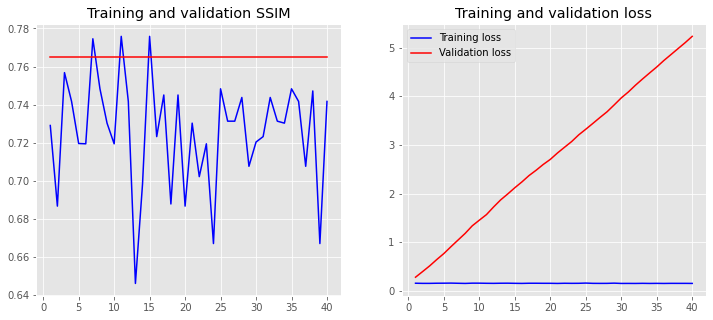

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

plt.figure(figsize=(12, 5))


acc = ssim_diff_list
acc_v = ssim_diff_list_v
loss_t = loss_list_train
loss_val = loss_list_train_v
x = range(1, len(acc)+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)


plt.plot(x, acc, 'b', label='Training SSIM')
plt.plot(x, acc_v, 'r', label='Validation SSIM')
plt.title('Training and validation SSIM')


plt.subplot(1, 2, 2)
plt.plot(x, loss_t, 'b', label='Training loss')
plt.plot(x, loss_val, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()



torch.Size([1, 19, 28, 28, 1])
torch.Size([1, 28, 28])


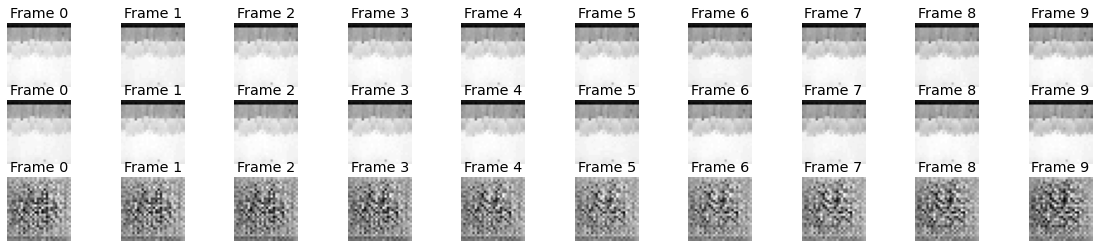

In [ ]:
fig, axes = plt.subplots(3, 10, figsize=(20, 4))
batch_size=5
sample_num = np.random.choice(range(batch_size))
# Pick the first ten frames from the sample
frames = original_list[sample_num][:10, ...]

# Pick the last ten frames from the sample
original_frames = orig_y_list[sample_num][9:, ...]


# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  ax.imshow(np.squeeze(original_list[0][0][0][idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

print(orig_y_list[0][0].shape)
for idx, ax in enumerate(axes[1]):
  ax.imshow(np.squeeze(orig_y_list[0][0][0][idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

# Plot the new frames.

print(recon_list[0][0][0].shape)
for idx, ax in enumerate(axes[2]):
  ax.imshow(np.squeeze(recon_list[0][0].detach()[idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

# Display the figure.
plt.show()


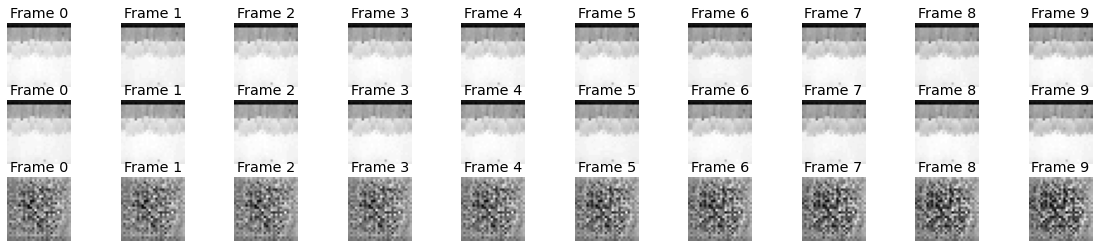

In [ ]:
fig, axes = plt.subplots(3, 10, figsize=(20, 4))
batch_size=5
sample_num = np.random.choice(range(batch_size))
# Pick the first ten frames from the sample
frames = original_list[sample_num][:10, ...]

# Pick the last ten frames from the sample
original_frames = orig_y_list[sample_num][9:, ...]


# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  ax.imshow(np.squeeze(original_list[0][0][0][idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

for idx, ax in enumerate(axes[1]):
  ax.imshow(np.squeeze(orig_y_list[0][0][0][idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

# Plot the new frames.

for idx, ax in enumerate(axes[2]):
  ax.imshow(np.squeeze(recon_list_v[0][0].detach()[idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

# Display the figure.
plt.show()


torch.Size([1, 28, 28])


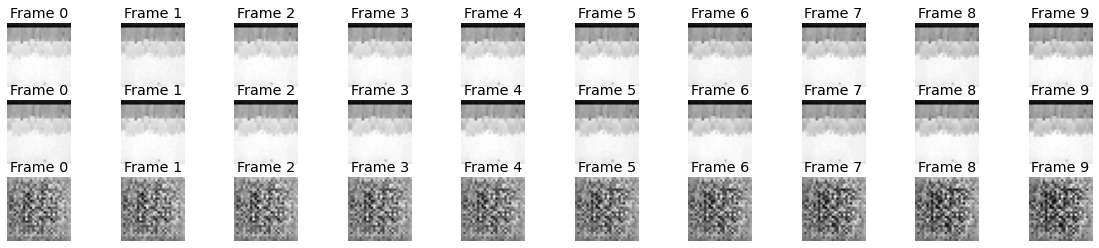

In [ ]:
fig, axes = plt.subplots(3, 10, figsize=(20, 4))
batch_size=5
sample_num = np.random.choice(range(batch_size))
# Pick the first ten frames from the sample
frames = original_list[sample_num][:10, ...]

# Pick the last ten frames from the sample
original_frames = orig_y_list[sample_num][9:, ...]


# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  ax.imshow(np.squeeze(original_list[0][0][0][idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

for idx, ax in enumerate(axes[1]):
  ax.imshow(np.squeeze(orig_y_list[0][0][0][idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

# Plot the new frames.
print(recon_list_test[0][0][0].shape)
for idx, ax in enumerate(axes[2]):
  ax.imshow(np.squeeze(recon_list_test[0][0].detach()[idx]), cmap="gray")
  ax.set_title(f"Frame {idx }")
  ax.axis("off")

# Display the figure.
plt.show()
